In [1]:


from kxor_code.problem_set_generation.kxor_dataset_generator import KXORDatasetGenerator


generator = KXORDatasetGenerator()
path = generator.generate_single_instance(
    folder_path="data/problem_instances/",
    n=10,
    k=4,
    m=5,
    rho=0.2
)

In [2]:
from kxor_code.problem_set_generation.kxor_instance import KXORInstance


instance = KXORInstance.load(path)
instance

KXORInstance(n=10, k=4, m=5, scopes=array([[0, 5, 8, 9],
       [1, 2, 3, 8],
       [2, 3, 7, 8],
       [2, 3, 8, 9],
       [1, 2, 5, 6]]), b=array([-1,  1, -1, -1,  1]), is_planted=True, rho=0.2, z=array([-1,  1,  1, -1,  1,  1, -1, -1, -1, -1]))

In [3]:

from kxor_code.problem_set_generation.kikuchi_matrix_generator import compute_kikuchi_matrix


kikuchi_matrix = compute_kikuchi_matrix(instance, ell=2)
print("Kikuchi matrix (ell=5):")
print(kikuchi_matrix.nnz)

Kikuchi matrix (ell=5):
30


In [4]:
kikuchi_matrix.nonzero()

(array([ 4, 44,  7, 38,  8, 37,  9, 28,  9, 35, 10, 22, 12, 20, 13, 19, 15,
        17, 17, 42, 17, 44, 21, 28, 22, 27, 22, 29, 23, 28], dtype=int32),
 array([44,  4, 38,  7, 37,  8, 28,  9, 35,  9, 22, 10, 20, 12, 19, 13, 17,
        15, 42, 17, 44, 17, 28, 21, 27, 22, 29, 22, 28, 23], dtype=int32))

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters to sweep
n_values = np.linspace(6,20,5, dtype=int)
k_values = [2, 4, 6]
constraint_density = [1,2,3,4,5]
instances_per_combo = 5
rho = 0.2
ells = [2,3,4,5]

os.makedirs("data/temp/", exist_ok=True)

results = []
for n in n_values:
    for k in k_values:
        for ell in ells:
            for d in constraint_density:
                    if ell < k/2:
                       continue  # skip invalid ell
                    # choose m relative to n (adjust if you prefer a different scaling)
                    m = int(d*n)
                    for rep in range(instances_per_combo):
                        path = generator.generate_single_instance(
                            folder_path="data/temp",
                            n=n,
                            k=k,
                            m=m,
                            rho=rho
                        )
                        inst = KXORInstance.load(path)
                        K = compute_kikuchi_matrix(inst, ell) # type: ignore
                        if K is None:
                            raise ValueError("Kikuchi matrix computation returned None")
                        if K.shape is None:
                            raise ValueError("Kikuchi matrix has undefined shape")
                        results.append({
                            "n": n,
                            "k": k,
                            "rep": rep,
                            "m": m,
                            "constraint_density": d,
                            "matrix_dim": K.shape[0],      # square matrix dimension
                            "nnz": K.nnz,                  # number of nonzeros
                            "z_ones": int((inst.z == 1).sum())  # simple summary of planted z
                        })

df = pd.DataFrame(results)



In [24]:
df["nnz"].value_counts()

nnz
0         75
66        30
20        25
96        20
1050      20
          ..
36400      5
72800      5
109200     5
145600     5
182000     5
Name: count, Length: 192, dtype: int64

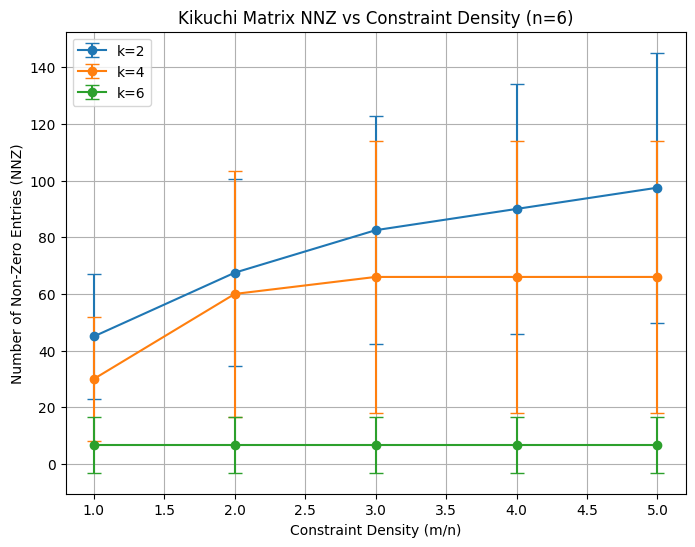

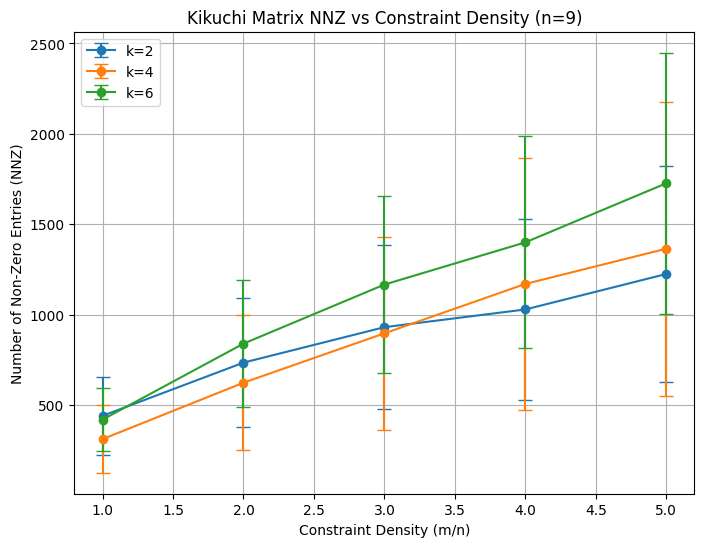

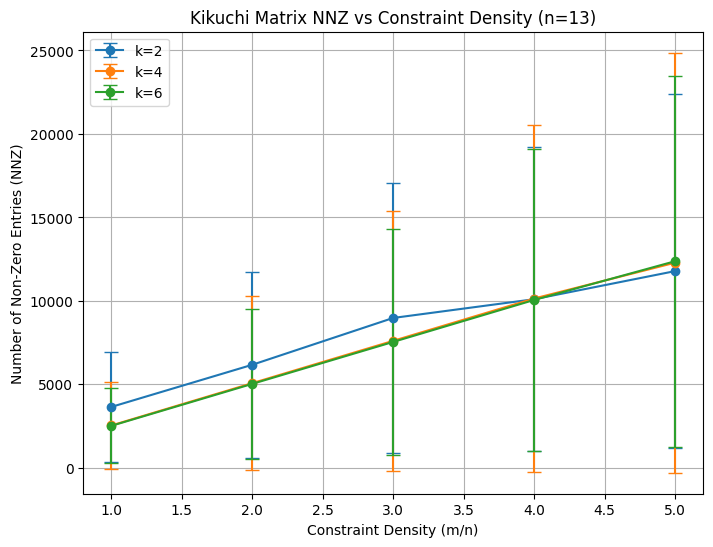

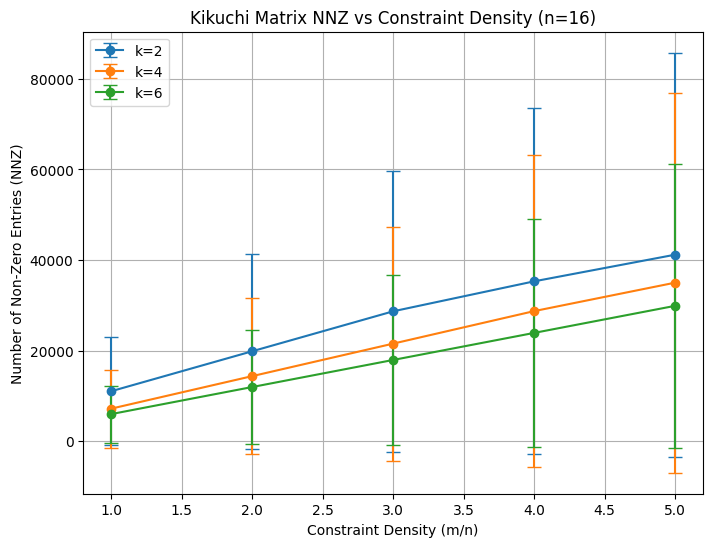

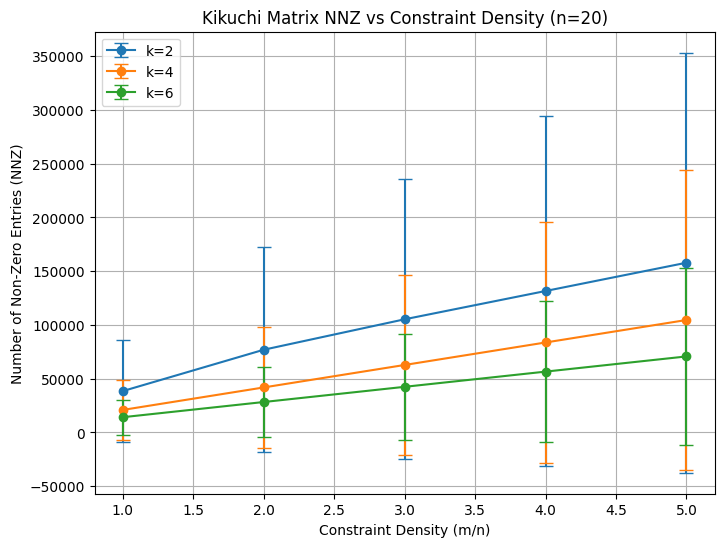

In [27]:
group = df.groupby(['n', 'k', 'constraint_density'])['nnz'].agg(['mean', 'std']).reset_index()

ns = sorted(df['n'].unique())
ks = sorted(df['k'].unique())

for n in ns:
    plt.figure(figsize=(8,6))
    for k in ks:
        subset = group[(group['n'] == n) & (group['k'] == k)]
        plt.errorbar(
            subset['constraint_density'], subset['mean'], yerr=subset['std'],
            label=f'k={k}', capsize=5, marker='o'
        )
    plt.title(f'Kikuchi Matrix NNZ vs Constraint Density (n={n})')
    plt.xlabel('Constraint Density (m/n)')
    plt.ylabel('Number of Non-Zero Entries (NNZ)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'kikuchi_nnz_vs_density_n{n}.png')
    plt.show()


In [ ]:
# Aggregate summary (mean and std) per (n,k)
summary = df.groupby(["n", "k"]).agg(
    matrix_dim_mean=("matrix_dim", "mean"),
    matrix_dim_std=("matrix_dim", "std"),
    nnz_mean=("nnz", "mean"),
    nnz_std=("nnz", "std")
).reset_index()

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

